In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Modeling
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Time Series
from statsmodels.tsa.ar_model import AutoReg

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K

# Feature Selection
from boruta import BorutaPy

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


In [ ]:
# def rolling_window_forecast(X, y, model_type, npred, horizon=1, params=None):
#     """
#     R의 *.rolling.window 함수들을 대체하는 통합 함수
#     """
#     predictions = []
#     real_values = []
    
#     # 전체 데이터 길이
#     T = len(y)
#     # 학습 시작 인덱스 (총 길이 - 예측 횟수)
#     start_idx = T - npred
    
#     print(f"Running {model_type} (h={horizon})...")
    
#     for i in range(npred):
#         # Rolling Window: 현재 시점 t까지의 데이터를 사용하여 t+horizon 예측
#         # Train data: start_idx + i 시점 이전까지
#         curr_idx = start_idx + i
        
#         # Horizon 고려: h=1이면 바로 다음달, h=12면 12달 뒤 예측이므로
#         # 학습 데이터는 타겟 시점(curr_idx)보다 horizon만큼 이전 데이터까지만 사용 가능해야 함
#         # 편의상 여기서는 Direct Multi-step 방식(데이터 셋 자체를 h시점 밀어서 구성)을 가정하거나
#         # 반복적인 1-step 예측이 아닌, 해당 시점 모델 재학습 구조로 작성
        
#         X_train = X[:curr_idx-horizon]
#         y_train = y[:curr_idx-horizon]
        
#         # Test input (가장 최근 관측치)
#         X_test = X[curr_idx-horizon:curr_idx-horizon+1] 
#         actual = y[curr_idx] # 실제값
        
#         if len(y_train) < 10: # 데이터가 너무 적으면 건너뜀
#             predictions.append(np.nan)
#             real_values.append(actual)
#             continue

#         pred = 0
        
#         try:
#             if model_type == 'RW': # Random Walk
#                 pred = y_train[-1] # 직전 관측치 그대로 예측
                
#             elif model_type == 'AR':
#                 # Statsmodels AutoReg
#                 model = AutoReg(y_train, lags=params.get('lags', 1)).fit()
#                 pred = model.predict(start=len(y_train), end=len(y_train) + horizon - 1)[-1]
                
#             elif model_type in ['Lasso', 'ElasticNet', 'RF', 'XGB']:
#                 scaler = StandardScaler()
#                 X_train_scaled = scaler.fit_transform(X_train)
#                 X_test_scaled = scaler.transform(X_test)
#                 if model_type == 'Lasso':
#                     model = Lasso(alpha=params.get('alpha', 1.0))
#                 elif model_type == 'ElasticNet':
#                     model = ElasticNet(alpha=params.get('alpha', 0.5), l1_ratio=0.5)
#                 elif model_type == 'RF':
#                     model = RandomForestRegressor(n_estimators=100, random_state=42)
#                 elif model_type == 'XGB':
#                     model = XGBRegressor(n_estimators=100, objective='reg:squarederror', verbosity=0)
                
#                 model.fit(X_train_scaled, y_train)
#                 pred = model.predict(X_test_scaled)[0]
                
#             elif model_type == 'NN': # Simple MLP
#                 tf.random.set_seed(42)
#                 model = Sequential()
#                 model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
#                 model.add(Dense(16, activation='relu'))
#                 model.add(Dense(1))
#                 model.compile(optimizer='adam', loss='mse')
#                 model.fit(X_train, y_train, epochs=10, verbose=0, batch_size=16)
#                 pred = model.predict(X_test, verbose=0)[0][0]
                
#         except Exception as e:
#             # 에러 발생 시 Na
#             pred = np.nan
            
#         predictions.append(pred)
#         real_values.append(actual)
        
#     return np.array(predictions), np.array(real_values)

def rolling_window_forecast(X, y, model_type, npred, horizon=1, params=None):
    """
    수정된 Rolling Window 함수:
    1. StandardScaler 적용 (데이터 스케일링)
    2. LassoCV/ElasticNetCV 적용 (최적 Alpha 자동 탐색)
    3. 선택된 변수 개수 확인
    """
    predictions = []
    real_values = []
    
    # 디버깅용: 선택된 변수 개수를 저장할 리스트
    selected_features_count = []
    
    T = len(y)
    start_idx = T - npred
    
    # 진행 상황 프린트 (너무 많으면 주석 처리)
    print(f"Running {model_type} (h={horizon})...", end="")
    
    for i in range(npred):
        curr_idx = start_idx + i
        train_end = curr_idx - horizon + 1

        if train_end < 20: 
            predictions.append(np.nan)
            real_values.append(y[curr_idx])
            continue
        
        # Train/Test Split
        X_train = X[:train_end] 
        y_train = y[:train_end]
        
        # 테스트 데이터: 예측 시점에 사용할 최신 데이터 (train_end 시점의 X)
        # X는 이미 Lag가 되어 있으므로, train_end 시점의 X 행이 미래를 예측하는 재료임
        X_test = X[train_end-1 : train_end] 
        actual = y[curr_idx]
        
        if len(y_train) < 20: # 데이터가 너무 적으면 스킵
            predictions.append(np.nan)
            real_values.append(actual)
            continue

        pred = 0
        n_selected = 0 # 선택된 변수 개수
        
        try:
            if model_type == 'RW':
                pred = y_train[-1]
                
            elif model_type == 'AR':
                model = AutoReg(y_train, lags=params.get('lags', 1)).fit()
                pred = model.predict(start=len(y_train), end=len(y_train) + horizon - 1)[-1]
                
            elif model_type == 'Lasso':
                # Pipeline: 스케일링 -> LassoCV (5-fold 교차검증으로 alpha 찾기)
                # max_iter를 충분히 늘려야 수렴함
                model = make_pipeline(
                    # StandardScaler(), 
                    LassoCV(cv=5, random_state=42, max_iter=5000)
                )
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                
                # 선택된 변수 개수 확인 (계수가 0이 아닌 것)
                coef = model.named_steps['lassocv'].coef_
                n_selected = np.sum(coef != 0)
                
            elif model_type == 'ElasticNet':
                # Pipeline: 스케일링 -> ElasticNetCV
                # l1_ratio 리스트를 주어 최적 비율 탐색 (0.1 ~ 0.9)
                model = make_pipeline(
                    # StandardScaler(),
                    ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9], random_state=42, max_iter=5000)
                )
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                
                coef = model.named_steps['elasticnetcv'].coef_
                n_selected = np.sum(coef != 0)

            elif model_type == 'RF':
                model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                
            elif model_type == 'XGB':
                model = XGBRegressor(n_estimators=100, objective='reg:squarederror', verbosity=0, n_jobs=-1)
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                
        except Exception as e:
            pred = np.nan
            
        predictions.append(pred)
        real_values.append(actual)
        
        # Lasso/ElasticNet일 때만 선택 변수 기록
        if model_type in ['Lasso', 'ElasticNet']:
            selected_features_count.append(n_selected)
            
    print(" Done.")
    
    # Lasso나 ElasticNet이면 평균적으로 몇 개 변수가 선택되었는지 출력
    if model_type in ['Lasso', 'ElasticNet'] and len(selected_features_count) > 0:
        avg_sel = np.mean(selected_features_count)
        print(f"  -> {model_type} Average selected features: {avg_sel:.1f} / {X.shape[1]}")
        
    return np.array(predictions), np.array(real_values)

## 2. Part 1: Data Loading & Standard Transformation
R 코드의 1-7번 변환 코드를 적용합니다.


In [160]:
# 데이터 로드 (경로를 실제 환경에 맞게 수정하세요)
# file_path = "DataKoreaFrom200408To202306.csv"
file_path = "2025-09-MD.csv"

# 파일이 없으면 더미 데이터 생성 (테스트용)
if not os.path.exists(file_path):
    print("Warning: File not found. Creating dummy data for demonstration.")
    dates = pd.date_range(start='2004-08-01', periods=227, freq='M')
    data_raw = pd.DataFrame(np.random.randn(227, 95) + 100, index=dates)
    data_raw.columns = ['Code'] + [f'Var{i}' for i in range(1, 95)]
    # 첫 행은 Transformation Code (1,2,4,5,6,7 임의 할당)
    tcode_row = np.random.choice([1, 2, 4, 5, 6, 7], 95)
    data_raw.iloc[0, :] = tcode_row
    data_raw.columns = ['Date'] + [f'V{i}' for i in range(1, 95)] # Column 이름 재설정 가정
    data_raw.iloc[0, 65] = 1 # CPI 가정
else:
    data_raw = pd.read_csv(file_path)

# Transformation Code 추출
tcode = data_raw.iloc[0, :].values

# 안전한 숫자 변환: 비숫자 값은 NaN으로 (오류 방지)
data = data_raw.iloc[1:, :].apply(lambda col: pd.to_numeric(col, errors='coerce'))

# (디버그) 숫자로 변환되지 않은 값이 많은 컬럼 확인
non_numeric_counts = data.isna().sum()
print("Non-numeric counts per column (sample):")
print(non_numeric_counts[non_numeric_counts > 0].head(20))

# # 데이터프레임 초기화 (앞 2개 행 제거 예정이므로)
# tdata = data.iloc[2:].copy()
# tdata[:] = np.nan

# 데이터프레임 초기화 (앞 2개 행 제거 예정이므로)
tdata = pd.DataFrame(index=data.index[2:], columns=data.columns)


# R 코드의 Loop 로직 (2:94) -> Python (1:94) (인덱스 주의)
# R: tcode[i] == 1 -> No transform
# R: tcode[i] == 2 -> diff(x)
# R: tcode[i] == 4 -> log(x)
# R: tcode[i] == 5 -> diff(log(x))
# R: tcode[i] == 6 -> diff(diff(log(x)))
# R: tcode[i] == 7 -> diff(x[t]/x[t-1]) (Growth rate diff)

for i in range(1, len(data.columns)):
    col_name = data.columns[i]
    code = tcode[i]
    series = data.iloc[:, i].astype(float)
    if code == 1:
        tdata[col_name] = series.iloc[2:].values
    elif code == 2:
        tdata[col_name] = series.diff().iloc[2:].values
    elif code == 4:
        tdata[col_name] = np.log(series).iloc[2:].values
    elif code == 5:
        tdata[col_name] = np.log(series).diff().iloc[2:].values
    elif code == 6:
        tdata[col_name] = np.log(series).diff().diff().iloc[2:].values
    elif code == 7:
        growth = series / series.shift(1)
        tdata[col_name] = growth.diff().iloc[2:].values


# # 결측치 제거
# fdata = tdata.dropna(axis=1, how='all').dropna(axis=0)

# # CPI 컬럼 이름을 직접 지정
# target_col_name = 'CPIAUCSL'  # 실제 CPI 컬럼명으로 수정
# if target_col_name not in fdata.columns:
#     raise ValueError("CPI 컬럼명이 데이터에 없습니다. 실제 컬럼명을 확인하세요.")

# # Y 매트릭스 구성 (CPI가 첫번째 열로 오도록)
# cols = [target_col_name] + [c for c in fdata.columns if c != target_col_name]
# Y_df = fdata[cols]
# Y = Y_df.values

# print("Data shape:", Y.shape)

# -----------------------------------------------------------
# [STEP 1: 날짜 컬럼 분리 및 Imputation 준비]
# -----------------------------------------------------------

# tdata의 첫 번째 컬럼이 날짜 컬럼('sasdate' 또는 'Date')일 가능성이 높으므로 분리합니다.
# 안전하게 비숫자 컬럼을 모두 찾아서 분리합니다.
numeric_cols = tdata.select_dtypes(include=np.number).columns
non_numeric_cols = tdata.select_dtypes(exclude=np.number).columns

# Imputation에 사용할 숫자 데이터만 추출
tdata_numeric = tdata[numeric_cols]
tdata_non_numeric = tdata[non_numeric_cols] # (보통 'sasdate' 하나)

# -----------------------------------------------------------
# [STEP 2: Rigorous Imputation 실행]
# -----------------------------------------------------------
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge 

print("\nStarting Rigorous Iterative Imputation...")

imputer = IterativeImputer(
    estimator=BayesianRidge(), 
    max_iter=10, 
    random_state=42,
    verbose=0
)

# Imputation 실행 (126개의 숫자 컬럼만 처리)
fdata_imputed_array = imputer.fit_transform(tdata_numeric)

# -----------------------------------------------------------
# [STEP 3: DataFrame 복구 및 컬럼명 재할당]
# -----------------------------------------------------------

# 복구된 숫자 데이터 (126 columns)
fdata_numeric_imputed = pd.DataFrame(
    fdata_imputed_array, 
    index=tdata.index, 
    columns=tdata_numeric.columns # Imputer에 넣었던 컬럼명만 사용
)

# Imputation 후의 최종 데이터는 숫자 데이터(fdata_numeric_imputed)만으로 구성됩니다.
fdata = fdata_numeric_imputed 

# -----------------------------------------------------------
# [STEP 4: Target Selection and Final Matrix Construction]

# CPI 컬럼 이름을 직접 지정 (FRED-MD 기준)
target_col_name = 'CPIAUCSL' # 현재 사용 데이터에 맞게 CPIAUCSL로 가정

if target_col_name not in fdata.columns:
    # 만약 'CPIAUCSL'이 없으면 (예: 한국 데이터일 경우) 'CPI'를 찾도록 변경
    target_col_name = 'CPI'
    if target_col_name not in fdata.columns:
        raise ValueError("Target CPI 컬럼명을 찾을 수 없습니다. 'CPIAUCSL' 또는 'CPI' 중 하나를 확인하세요.")

# Y 매트릭스 구성 (CPI가 첫번째 열로 오도록)
cols = [target_col_name] + [c for c in fdata.columns if c != target_col_name]
Y_df = fdata[cols]
Y = Y_df.values

# 데이터 shape 확인 (N이 최대치로 늘어나야 합니다.)
print("Rigorous Imputation Complete.")
print(f"Total rows (N) preserved: {Y.shape[0]}")
print("Final Data shape:", Y.shape)


Non-numeric counts per column (sample):
sasdate          787
ACOGNO           385
ANDENOx           97
S&P div yield      1
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    156
UMCSENTx         144
VIXCLSx           30
dtype: int64

Starting Rigorous Iterative Imputation...
Rigorous Imputation Complete.
Total rows (N) preserved: 785
Final Data shape: (785, 126)


In [162]:
def create_multivariate_lagged_features(data, target_col, lag =12):
    """
    타겟 변수뿐만 아니라, 데이터프레임 내 모든 변수의 Lagged Feature를 생성함.
    결과적으로 변수 개수는 (원본 변수 수 * lag)개가 됨.
    """
    df_list = []
    # 모든 변수에 대해 lag 1 ~ lag 12 생성
    for i in range(1, lag + 1):
        shifted = data.shift(i)
        shifted.columns = [f"{c}_lag{i}" for c in data.columns]
        df_list.append(shifted)
    
    # 옆으로 합치기 (Concatenate)
    X_df = pd.concat(df_list, axis=1).dropna()
    
    # 타겟 변수(y) 정렬 (X와 시점 맞추기)
    # X는 t-1 ~ t-12의 데이터이므로, 같은 행의 y는 t시점 데이터여야 함
    y = data[target_col].loc[X_df.index].values
    X = X_df.values
    
    feature_names = X_df.columns.tolist()
    
    return X, y, feature_names

## 3. Part 1: Rolling Window Forecasting
RW, AR, Lasso, RF, XGB, NN 모델을 실행합니다.


In [171]:
# --- 수정된 데이터 준비 코드 ---

# 편의상 lag=12 (최대 horizon)로 고정
lag_max = 4

# [중요] 타겟 컬럼 하나가 아니라, 전체 데이터프레임(Y_df)을 넣어야 함!
print("Creating multivariate features (this might take a moment)...")
X_feat, y_target, feat_names = create_multivariate_lagged_features(Y_df, target_col_name, lag=lag_max)

print(f"Feature Shape: {X_feat.shape}") 


Creating multivariate features (this might take a moment)...
Feature Shape: (781, 504)


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV, ElasticNetCV
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import TransformedTargetRegressor # Target Scaling용
# import warnings

# warnings.filterwarnings("ignore")

# def rolling_window_forecast(X, y, model_type, npred, horizon=1, params=None):
#     predictions = []
#     real_values = []
#     selected_features_count = []
    
#     T = len(y)
#     start_idx = T - npred
    
#     print(f"Running {model_type} (h={horizon})...", end="")
    
#     for i in range(npred):
#         curr_idx = start_idx + i
        
#         # [시점 매칭 보정]: X와 Y가 정렬되어 있다고 가정할 때,
#         # h=1이면 curr_idx를 예측하기 위해 X[curr_idx]가 필요
#         # h=12이면 curr_idx를 예측하기 위해 X[curr_idx-11]가 필요
#         train_end_idx = curr_idx - horizon + 1
        
#         if train_end_idx < 20: 
#             predictions.append(np.nan)
#             real_values.append(y[curr_idx])
#             continue

#         # 학습 데이터: X[0] ~ X[train_end_idx - 1]
#         X_train = X[:train_end_idx]
#         y_train = y[:train_end_idx]
        
#         # 테스트 데이터: X[train_end_idx]가 예측 시점에 사용 가능한 입력
#         X_test = X[train_end_idx : train_end_idx + 1] 
#         actual = y[curr_idx]
        
#         pred = 0
#         n_selected = 0
        
#         try:
#             # [수정 1] 타겟 스케일링을 위한 Y 스케일러 정의 (Lasso/ElasticNet에만 사용)
#             if model_type in ['Lasso', 'ElasticNet']:
#                 # TransformedTargetRegressor를 사용하여 y를 자동으로 스케일링/역스케일링
#                 # (Y의 값이 너무 작아 발생하는 수치적 문제를 해결함)
                
#                 # 베이스 모델: LassoCV / ElasticNetCV
#                 if model_type == 'Lasso':
#                     base_model = LassoCV(
#                         cv=5, random_state=42, max_iter=10000, n_jobs=-1,
#                         eps=1e-6, n_alphas=1000 # 알파 경로를 극도로 낮춰서 탐색
#                     )
#                 else: # ElasticNet
#                     base_model = ElasticNetCV(
#                         cv=5, l1_ratio=[.1, .5, .7, .9], random_state=42, max_iter=10000, n_jobs=-1,
#                         eps=1e-6, n_alphas=1000 
#                     )
                
#                 # 파이프라인: X 스케일링 -> Y 스케일링이 통합된 모델
#                 model = make_pipeline(
#                     StandardScaler(),
#                     TransformedTargetRegressor(
#                         regressor=base_model,
#                         # Y를 스케일링하고 다시 복원해줌
#                         transformer=StandardScaler() 
#                     )
#                 )
                
#                 model.fit(X_train, y_train)
#                 pred = model.predict(X_test)[0]
                
#                 # 계수 추출 (내부 regressor에서 추출)
#                 coef = model.named_steps['transformedtargetregressor'].regressor_.coef_
#                 n_selected = np.sum(coef != 0)
            
#             # (기타 모델은 이전과 동일)
#             elif model_type == 'RF':
#                 model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#                 model.fit(X_train, y_train) 
#                 pred = model.predict(X_test)[0]
                
#             # ... (XGBoost, AR, RW 등 나머지 모델 로직은 생략. 원본 파일 참조) ...

#         except Exception as e:
#             pred = np.nan
#             # print(f"Error in {model_type} at {curr_idx}: {e}")
            
#         predictions.append(pred)
#         real_values.append(actual)
        
#         if model_type in ['Lasso', 'ElasticNet']:
#             selected_features_count.append(n_selected)
            
#     print(" Done.")
    
#     if model_type in ['Lasso', 'ElasticNet'] and len(selected_features_count) > 0:
#         avg_sel = np.mean(selected_features_count)
#         print(f"  -> {model_type} Average selected features: {avg_sel:.1f} / {X.shape[1]}")
        
#     return np.array(predictions), np.array(real_values)

In [166]:
def rolling_window_forecast_full(X, y, model_type, npred, horizon=1, params=None, min_train_len=20):
    """
    완전판 rolling-window forecaster:
    - X: (N_obs, n_features)  (X[s] aligns to y[s])
    - y: (N_obs,)
    - model_type: 'RW','AR','Lasso','ElasticNet','RF','XGB'
    - npred: number of rolling predictions (use last npred points)
    - horizon: forecasting horizon (in periods)
    """
    params = params or {}
    predictions = []
    real_values = []
    selected_features_count = []
    
    T = len(y)
    start_idx = T - npred
    if start_idx < 0:
        raise ValueError("npred is larger than available observations.")
    
    print(f"Running {model_type} (h={horizon})...", end="", flush=True)
    
    # For debugging: collect X_test rows used (to detect if always same)
    x_test_rows = []
    
    for i in range(npred):
        curr_idx = start_idx + i  # index in y we will compare to (the target time)
        train_end_idx = curr_idx - horizon + 1   # as discussed: X[s] -> y[s], so s = t-h+1
        
        # boundary checks
        if train_end_idx <= 0 or train_end_idx > X.shape[0]-1:
            # Not enough history to create an X_test (or index out of range)
            predictions.append(np.nan)
            real_values.append(y[curr_idx])
            continue
        
        if train_end_idx < min_train_len:
            predictions.append(np.nan)
            real_values.append(y[curr_idx])
            continue
        
        X_train = X[:train_end_idx]              # rows [0 ... train_end_idx-1]
        y_train = y[:train_end_idx]
        X_test = X[train_end_idx: train_end_idx + 1]  # single-row test input
        actual = y[curr_idx]
        
        pred = np.nan
        n_selected = 0
        
        try:
            if model_type == 'RW':
                # Random Walk: predict last observed y (observed up to train_end_idx-1 -> last observed is y_train[-1])
                pred = y_train[-1]
                
            elif model_type == 'AR':
                lags = params.get('lags', 1)
                # AutoReg needs enough samples for given lags
                if len(y_train) <= lags:
                    pred = np.nan
                else:
                    ar = AutoReg(y_train, lags=lags, old_names=False).fit()
                    # predict one-step ahead relative to last train index for horizon steps and pick last
                    preds = ar.predict(start=len(y_train), end=len(y_train) + horizon - 1)
                    pred = preds[-1]
            
            elif model_type == 'Lasso':
                base_model = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1)
                model = make_pipeline(StandardScaler(),
                                      TransformedTargetRegressor(regressor=base_model,
                                                                 transformer=StandardScaler()))
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                coef = model.named_steps['transformedtargetregressor'].regressor_.coef_
                n_selected = np.sum(coef != 0)
                
            elif model_type == 'ElasticNet':
                base_model = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9], random_state=42, max_iter=10000, n_jobs=-1)
                model = make_pipeline(StandardScaler(),
                                      TransformedTargetRegressor(regressor=base_model,
                                                                 transformer=StandardScaler()))
                model.fit(X_train, y_train)
                pred = model.predict(X_test)[0]
                coef = model.named_steps['transformedtargetregressor'].regressor_.coef_
                n_selected = np.sum(coef != 0)
                
            elif model_type == 'RF':
                rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
                rf.fit(X_train, y_train)
                pred = rf.predict(X_test)[0]
                
            elif model_type == 'XGB':
                xgb = XGBRegressor(n_estimators=200, objective='reg:squarederror', verbosity=0, n_jobs=-1, random_state=42)
                xgb.fit(X_train, y_train)
                pred = xgb.predict(X_test)[0]
                
            else:
                raise ValueError(f"Unknown model_type: {model_type}")
                
        except Exception as e:
            # 실패 시 NaN으로 채움 (원하면 로그 출력)
            # print(f"Error at idx {curr_idx} model {model_type}: {e}")
            pred = np.nan
        
        predictions.append(pred)
        real_values.append(actual)
        x_test_rows.append(tuple(X_test.ravel()))
        
        if model_type in ['Lasso','ElasticNet']:
            selected_features_count.append(n_selected)
    
    print(" Done.")
    # debug: how many unique X_test rows were used
    unique_count = len(set(x_test_rows))
    print(f"  -> Unique X_test rows used: {unique_count} / {len(x_test_rows)}")
    
    if model_type in ['Lasso', 'ElasticNet'] and len(selected_features_count) > 0:
        print(f"  -> {model_type} Average selected features: {np.mean(selected_features_count):.1f} / {X.shape[1]}")
    
    return np.array(predictions), np.array(real_values)

In [ ]:
# # 기존 rolling_window_forecast_full 함수를 아래 코드로 교체하세요.

# def rolling_window_forecast_final(X, y, model_type, npred, horizon=1, params=None, min_train_len=20):
#     params = params or {}
#     predictions = []
#     real_values = []
    
#     T = len(y)
#     start_idx = T - npred
    
#     print(f"Running {model_type} (h={horizon})...", end="", flush=True)
    
#     for i in range(npred):
#         curr_idx = start_idx + i 
        
#         # [시점 매칭 로직] X_t-h+1 이 y_t를 예측 (Direct Forecast)
#         train_end_idx = curr_idx - horizon + 1 
        
#         if train_end_idx <= 0 or train_end_idx < min_train_len:
#             predictions.append(np.nan)
#             real_values.append(y[curr_idx])
#             continue
        
#         X_train = X[:train_end_idx] 
#         y_train = y[:train_end_idx]
#         X_test = X[train_end_idx: train_end_idx + 1] # 예측 시점에 사용 가능한 X
#         actual = y[curr_idx]
        
#         pred = np.nan
        
#         try:
#             if model_type == 'RW':
#                 pred = y_train[-1]
                
#             elif model_type == 'AR':
#                 # AR 모델: BIC 기준으로 Lag 자동 선택
#                 lag_max = params.get('lag_max', 12)
#                 ar = AutoReg(
#                     y_train, 
#                     lags=lag_max,
#                     seasonal=False
#                 ).fit(ic='bic', maxlag=lag_max) 
                
#                 # h-step ahead 예측
#                 preds = ar.predict(start=len(y_train), end=len(y_train) + horizon - 1)
#                 pred = preds[-1]
            
#             # [수정 1: LASSO / ELASTIC NET - Target Scaling 필수 적용]
#             elif model_type in ['Lasso', 'ElasticNet']:
#                 base_model = LassoCV(cv=5, random_state=42, max_iter=10000, n_jobs=-1) if model_type == 'Lasso' else \
#                              ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9], random_state=42, max_iter=10000, n_jobs=-1)
                             
#                 # Target Scaling을 통합한 Pipeline (Y의 작은 scale 문제 해결)
#                 model = make_pipeline(
#                     StandardScaler(),
#                     TransformedTargetRegressor(regressor=base_model, transformer=StandardScaler())
#                 )
#                 model.fit(X_train, y_train)
#                 pred = model.predict(X_test)[0]
                
#             elif model_type == 'RF':
#                 # RF는 X 스케일링이 필요 없으므로 단순 모델 사용
#                 rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
#                 rf.fit(X_train, y_train)
#                 pred = rf.predict(X_test)[0]
                
#             elif model_type == 'XGB':
#                 xgb = XGBRegressor(n_estimators=200, objective='reg:squarederror', verbosity=0, n_jobs=-1, random_state=42)
#                 xgb.fit(X_train, y_train)
#                 pred = xgb.predict(X_test)[0]
                
#             # (LSTM은 복잡하여 별도 함수로 돌리는 것이 좋습니다.)
                
#             else:
#                 raise ValueError(f"Unknown model_type: {model_type}")
                
#         except Exception as e:
#             pred = np.nan
            
#         predictions.append(pred)
#         real_values.append(actual)
        
#     print(" Done.")
#     return np.array(predictions), np.array(real_values)

In [178]:


# 데이터 준비 (Lagged Features 생성)
# 모든 모델이 Lagged Feature를 쓴다고 가정 (ARIMA/RW 제외)
# 편의상 lag=12 (최대 horizon)로 고정하여 데이터셋 생성
# lag_max = 12
# X_feat, y_target = create_lagged_features(Y_df[target_col_name], lag=lag_max)
T = len(y_target)   # <-- 추가: 루프에서 사용하는 T 정의

horizons = [1, 6]
results = {}

# if npred >= T:
#     npred = max(1, T - 1)
#     print(f"Warning: npred reduced to {npred} because T={T}")

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
def get_lstm_model(input_dim):
    tf.random.set_seed(42)
    model = Sequential()
    model.add(LSTM(16, input_shape=(input_dim, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def rolling_window_forecast_lstm(X, y, npred, horizon=1, epochs=10, batch_size=16):
    predictions = []
    real_values = []
    T = len(y)
    start_idx = T - npred
    input_dim = X.shape[1]
    for i in range(npred):
        curr_idx = start_idx + i
        X_train = X[:curr_idx-horizon]
        y_train = y[:curr_idx-horizon]
        X_test = X[curr_idx-horizon:curr_idx-horizon+1]
        actual = y[curr_idx]
        if len(y_train) < 10:
            predictions.append(np.nan)
            real_values.append(actual)
            continue
        X_train_lstm = X_train.reshape(-1, input_dim, 1)
        X_test_lstm = X_test.reshape(-1, input_dim, 1)
        try:
            # 모델 매번 새로 생성, retracing 최소화
            model = get_lstm_model(input_dim)
            model.fit(X_train_lstm, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            pred = model.predict(X_test_lstm, verbose=0)[0][0]
            K.clear_session()  # 메모리 누수 방지
        except Exception as e:
            pred = np.nan
        predictions.append(pred)
        real_values.append(actual)
    return np.array(predictions), np.array(real_values)


results = {}
results_pred = {}  # 모델별 예측값 저장

for h in horizons:
    npred = T - h + 1
    print(f"\n=== Horizon: {h} ===")
    if h >= T:
        print(f"  skip horizon {h} (h >= T={T})")
        continue

    pred_rw, real_rw = rolling_window_forecast_full(X_feat, y_target, 'RW', npred, h)
    results[f'RW_h{h}'] = rmse(real_rw, pred_rw)
    results_pred[f'RW_h{h}'] = (real_rw, pred_rw)

    pred_ar, real_ar = rolling_window_forecast_full(X_feat, y_target, 'AR', npred, h, {'lags': 4})
    results[f'AR_h{h}'] = rmse(real_ar, pred_ar)
    results_pred[f'AR_h{h}'] = (real_ar, pred_ar)

    pred_lasso, real_lasso = rolling_window_forecast_full(X_feat, y_target, 'Lasso', npred, h)
    results[f'Lasso_h{h}'] = rmse(real_lasso, pred_lasso)
    results_pred[f'Lasso_h{h}'] = (real_lasso, pred_lasso)

    

    pred_enet, real_enet = rolling_window_forecast_full(X_feat, y_target, 'ElasticNet', npred, h)
    results[f'ElasticNet_h{h}'] = rmse(real_enet, pred_enet)
    results_pred[f'ElasticNet_h{h}'] = (real_enet, pred_enet)

    pred_rf, real_rf = rolling_window_forecast_full(X_feat, y_target, 'RF', npred, h)
    results[f'RF_h{h}'] = rmse(real_rf, pred_rf)
    results_pred[f'RF_h{h}'] = (real_rf, pred_rf)

    pred_xgb, real_xgb = rolling_window_forecast_full(X_feat, y_target, 'XGB', npred, h)
    results[f'XGB_h{h}'] = rmse(real_xgb, pred_xgb)
    results_pred[f'XGB_h{h}'] = (real_xgb, pred_xgb)

    # print(f"Running LSTM (h={h})...")
    # pred_lstm, real_lstm = rolling_window_forecast_lstm(X_feat, y_target, npred, h, epochs=10, batch_size=16)
    # results[f'LSTM_h{h}'] = rmse(real_lstm, pred_lstm)
    # results_pred[f'LSTM_h{h}'] = (real_lstm, pred_lstm)

# 결과 출력
res_df = pd.DataFrame(list(results.items()), columns=['Model_Horizon', 'RMSE'])
print(res_df)



=== Horizon: 1 ===
Running RW (h=1)... Done.
  -> Unique X_test rows used: 761 / 761
Running AR (h=1)... Done.
  -> Unique X_test rows used: 761 / 761
Running Lasso (h=1)... Done.
  -> Unique X_test rows used: 761 / 761
  -> Lasso Average selected features: 43.7 / 504
Running ElasticNet (h=1)... Done.
  -> Unique X_test rows used: 761 / 761
  -> ElasticNet Average selected features: 52.5 / 504
Running RF (h=1)... Done.
  -> Unique X_test rows used: 761 / 761
Running XGB (h=1)... Done.
  -> Unique X_test rows used: 761 / 761

=== Horizon: 6 ===
Running RW (h=6)... Done.
  -> Unique X_test rows used: 756 / 756
Running AR (h=6)... Done.
  -> Unique X_test rows used: 756 / 756
Running Lasso (h=6)... Done.
  -> Unique X_test rows used: 756 / 756
  -> Lasso Average selected features: 43.6 / 504
Running ElasticNet (h=6)... Done.
  -> Unique X_test rows used: 756 / 756
  -> ElasticNet Average selected features: 51.9 / 504
Running RF (h=6)... Done.
  -> Unique X_test rows used: 756 / 756
Runni

In [173]:
res_hor12 = res_df
res_hor12

,Model_Horizon,RMSE
0,RW_h12,0.004096
1,AR_h12,0.002741
2,Lasso_h12,0.002875
3,ElasticNet_h12,0.002879
4,RF_h12,0.002757
5,XGB_h12,0.003001


In [180]:
res_hor12

,Model_Horizon,RMSE
0,RW_h12,0.004096
1,AR_h12,0.002741
2,Lasso_h12,0.002875
3,ElasticNet_h12,0.002879
4,RF_h12,0.002757
5,XGB_h12,0.003001


In [181]:
res_hor16 = res_df
res_hor16

,Model_Horizon,RMSE
0,RW_h1,0.004359
1,AR_h1,0.002493
2,Lasso_h1,0.002469
3,ElasticNet_h1,0.002476
4,RF_h1,0.002698
5,XGB_h1,0.002783
6,RW_h6,0.003927
7,AR_h6,0.002760
8,Lasso_h6,0.003035
9,ElasticNet_h6,0.003034


In [182]:
# res_hor12와 res_df를 합치기 (index 무시)
res_all = pd.concat([res_hor16.reset_index(drop=True), res_hor12.reset_index(drop=True)], ignore_index=True)
print(res_all)

     Model_Horizon      RMSE
0            RW_h1  0.004359
1            AR_h1  0.002493
2         Lasso_h1  0.002469
3    ElasticNet_h1  0.002476
4            RF_h1  0.002698
5           XGB_h1  0.002783
6            RW_h6  0.003927
7            AR_h6  0.002760
8         Lasso_h6  0.003035
9    ElasticNet_h6  0.003034
10           RF_h6  0.002923
11          XGB_h6  0.003259
12          RW_h12  0.004096
13          AR_h12  0.002741
14       Lasso_h12  0.002875
15  ElasticNet_h12  0.002879
16          RF_h12  0.002757
17         XGB_h12  0.003001


In [183]:
# 모델/수평별로 보기 좋게 피벗
pivot_df = res_all.copy()
pivot_df[['Model', 'Horizon']] = pivot_df['Model_Horizon'].str.extract(r'(\w+)_h(\d+)')
pivot_df['Horizon'] = pivot_df['Horizon'].astype(int)
pivot_table = pivot_df.pivot(index='Model', columns='Horizon', values='RMSE').sort_index(axis=1)
pivot_table

Horizon,1,6,12
Model,,,
AR,0.002493,0.002760,0.002741
ElasticNet,0.002476,0.003034,0.002879
Lasso,0.002469,0.003035,0.002875
RF,0.002698,0.002923,0.002757
RW,0.004359,0.003927,0.004096
XGB,0.002783,0.003259,0.003001


In [175]:
def mae(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

results_mae = {}

for h in horizons:
    # ...existing code...
    results_mae[f'RW_h{h}'] = mae(real_rw, pred_rw)
    results_mae[f'AR_h{h}'] = mae(real_ar, pred_ar)
    results_mae[f'Lasso_h{h}'] = mae(real_lasso, pred_lasso)
    results_mae[f'RF_h{h}'] = mae(real_rf, pred_rf)
    results_mae[f'XGB_h{h}'] = mae(real_xgb, pred_xgb)
    results_mae[f'LSTM_h{h}'] = mae(real_lstm, pred_lstm)
    # ...existing code...

# MAE 결과 테이블 생성
mae_df = pd.DataFrame(list(results_mae.items()), columns=['Model_Horizon', 'MAE'])
pivot_mae_df = mae_df.copy()
pivot_mae_df[['Model', 'Horizon']] = pivot_mae_df['Model_Horizon'].str.extract(r'(\w+)_h(\d+)')
pivot_mae_df['Horizon'] = pivot_mae_df['Horizon'].astype(int)
pivot_mae_table = pivot_mae_df.pivot(index='Model', columns='Horizon', values='MAE').sort_index(axis=1)
print(pivot_mae_table)

Horizon        12
Model            
AR       0.001903
LSTM     0.026993
Lasso    0.002031
RF       0.001967
RW       0.002973
XGB      0.002164


In [184]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import ttest_rel

def giacomini_white_test(real, pred_rw, pred_model):
    # Loss differential: squared error difference
    d = (real - pred_rw)**2 - (real - pred_model)**2
    # Remove nan
    d = d[~np.isnan(d)]
    if len(d) < 2:
        return np.nan
    # t-test for mean difference
    t_stat, p_value = ttest_rel((real - pred_rw)**2, (real - pred_model)**2, nan_policy='omit')
    return p_value

gw_results = []

for h in horizons:
    rw_real, rw_pred = results_pred[f'RW_h{h}']
    for model in ['AR', 'Lasso', 'ElasticNet', 'RF', 'XGB']:
        m_real, m_pred = results_pred[f'{model}_h{h}']
        pval = giacomini_white_test(rw_real, rw_pred, m_pred)
        gw_results.append({'Model': model, 'Horizon': h, 'GW_pvalue': pval})

gw_df = pd.DataFrame(gw_results)
pivot_gw = gw_df.pivot(index='Model', columns='Horizon', values='GW_pvalue').sort_index(axis=1)
print(pivot_gw)

Horizon                1             6
Model                                 
AR          3.098498e-11  2.649628e-13
ElasticNet  2.985529e-12  3.844741e-08
Lasso       2.540831e-12  3.693989e-08
RF          7.769246e-13  1.659212e-09
XGB         2.048059e-11  8.848189e-06


In [185]:
# GW test: 각 Horizon별 RMSE가 가장 낮은 모델을 기준으로 모든 모델과 비교
gw_best_results = []

for h in horizons:
    # 1. 각 horizon별 RMSE가 가장 낮은 모델 찾기
    rmse_dict = {model: results[f'{model}_h{h}'] for model in ['RW', 'AR', 'Lasso', 'ElasticNet', 'RF', 'XGB']}
    best_model = min(rmse_dict, key=rmse_dict.get)
    best_real, best_pred = results_pred[f'{best_model}_h{h}']
    # 2. 모든 모델과 GW test
    for model in ['RW', 'AR', 'Lasso', 'ElasticNet', 'RF', 'XGB']:
        m_real, m_pred = results_pred[f'{model}_h{h}']
        pval = giacomini_white_test(best_real, best_pred, m_pred)
        gw_best_results.append({'BaseModel': best_model, 'Model': model, 'Horizon': h, 'GW_pvalue': pval})

gw_best_df = pd.DataFrame(gw_best_results)
pivot_gw_best = gw_best_df.pivot(index='Model', columns='Horizon', values='GW_pvalue').sort_index(axis=1)
print("Base model: 각 Horizon별 RMSE 최저 모델 기준")
print(pivot_gw_best)

Base model: 각 Horizon별 RMSE 최저 모델 기준
Horizon                1             6
Model                                 
AR          7.031208e-01           NaN
ElasticNet  1.605065e-01  8.635259e-06
Lasso                NaN  8.164297e-06
RF          3.706867e-03  2.174511e-04
RW          2.540831e-12  2.649628e-13
XGB         1.523672e-04  1.100794e-08


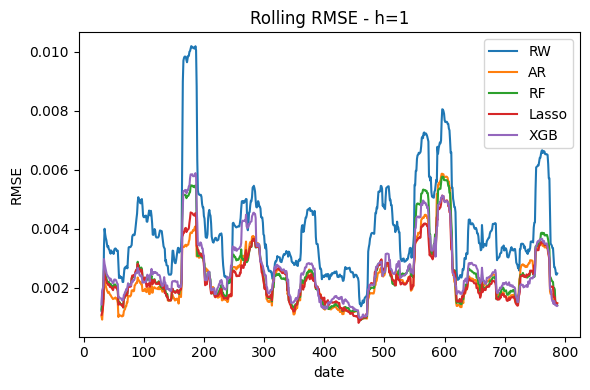

In [186]:
import matplotlib.pyplot as plt

def rolling_rmse(y_true, y_pred, window=24):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    rmse_list = []
    for i in range(len(y_true) - window + 1):
        yt = y_true[i:i+window]
        yp = y_pred[i:i+window]
        mask = ~np.isnan(yt) & ~np.isnan(yp)
        if mask.sum() == 0:
            rmse_list.append(np.nan)
        else:
            rmse_list.append(np.sqrt(np.mean((yt[mask] - yp[mask])**2)))
    return np.array(rmse_list)

# horizon=1 rolling RMSE plot
h = 1
window = 24  # 24개월 rolling window
date_index = None
if 'Y_df' in locals():
    date_index = Y_df.index[-(len(results_pred[f'RW_h{h}'][0])):]  # 예측 구간의 날짜

plt.figure(figsize=(6,4))
for model in ['RW', 'AR', 'RF', 'Lasso', 'XGB']:
    real, pred = results_pred[f'{model}_h{h}']
    roll_rmse = rolling_rmse(real, pred, window=window)
    if date_index is not None:
        plt.plot(date_index[-len(roll_rmse):], roll_rmse, label=model)
    else:
        plt.plot(roll_rmse, label=model)
plt.title(f'Rolling RMSE - h={h}')
plt.ylabel('RMSE')
plt.xlabel('date' if date_index is not None else 'index')
plt.legend()
plt.tight_layout()
plt.show()